# Plotting epi parameter estimates from bayesian logistic growth model 

### setup

In [1]:
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(magrittr)
library(lubridate)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   0.3.5      
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
my_theme <- function() {
    theme_bw() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=12, face="bold"),
        axis.title.y = element_text(color="black", size=12, face="bold"),
        axis.text.x = element_text(size= 10, vjust=0.5),
        axis.text.y = element_text(size = 10)
        )
}

options(repr.plot.width=14, repr.plot.height=8)

## posterior distribution of netau under logistic growth model 

### Read in TSV 

In [3]:
path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/logistic/'
netau <- read.table(paste0(path,'logistic_growth_t50.tsv'), sep='\t', header=T)
head(netau)

,time,date,datetime,milliseconds,mean,median,upper,lower
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022.797,2022-10-18,2022-10-18T08:00:00,1.666080e+12,25.31316,20.31142,49.88838,11.43242
2,2022.790,2022-10-15,2022-10-15T18:05:03,1.665857e+12,24.82678,20.29794,49.80448,11.43185
3,2022.783,2022-10-13,2022-10-13T04:10:06,1.665634e+12,24.45672,20.27839,49.49118,11.43120
4,2022.776,2022-10-10,2022-10-10T14:15:09,1.665411e+12,24.15676,20.24913,49.10957,11.43046
5,2022.769,2022-10-08,2022-10-08T00:20:12,1.665188e+12,23.90278,20.22491,48.70991,11.42962
6,2022.762,2022-10-05,2022-10-05T10:25:15,1.664966e+12,23.68077,20.21632,48.39194,11.42868


In [53]:
# format date 
netau <- netau %>% mutate(month = months(as.Date(datetime)))
netau <- netau %>% mutate(datetime = as_date(date))

In [50]:
## specify the 15th of each/every other month? 

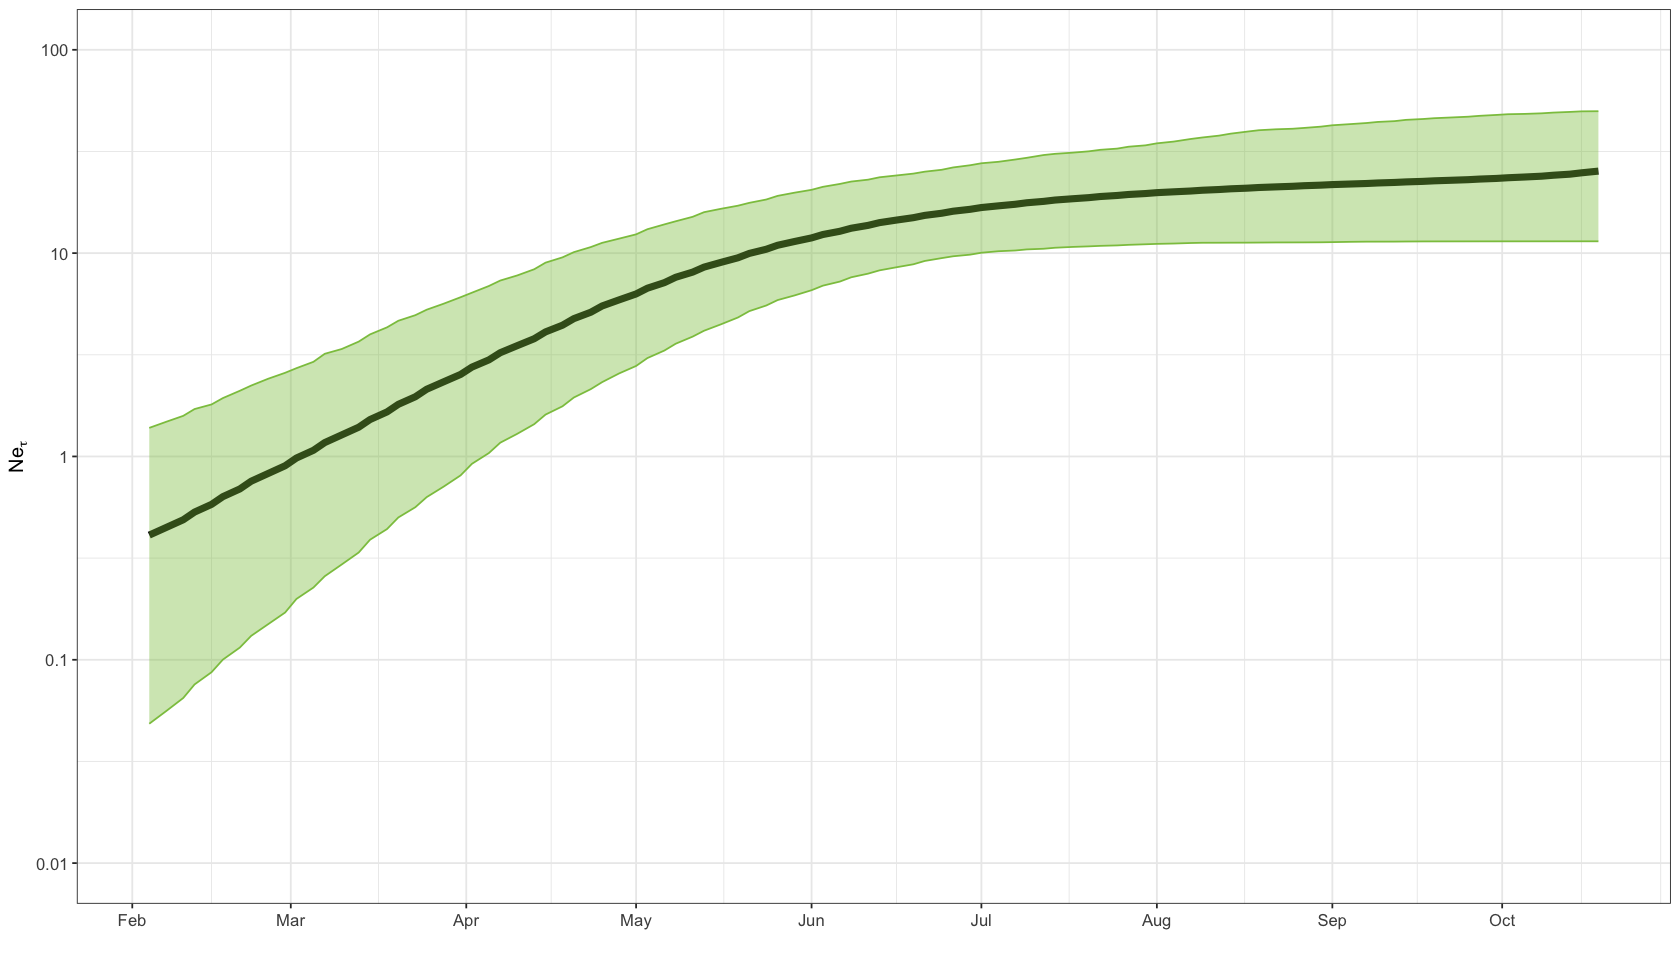

In [61]:
plot_netau <- netau %>% ggplot(aes(x=datetime, y=mean)) + 
         geom_line(size=2, color='black') +
         geom_ribbon(aes(ymin=lower, ymax=upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
         ylab(bquote(Ne[tau])) + xlab('') + 
         scale_y_continuous(trans='log10', breaks=c(.01, .1, 1, 10, 100), limits=c(.01,100), labels=c( .01, .1, 1, 10, 100)) +
         scale_x_date(date_labels = "%b", date_breaks='months') +
         my_theme()       

plot_netau

## Deriving Ne from logistic Netau

### SIR dynamics: 

per-day rate of increase (r) = contact rate (β) - recovery rate (γ)

β = r + γ

... 

According to WHO, hmpxv1 incubation period is 5-21 days.  
Early in the pandemic, S = 1, so generation time is inferred from contact rate alone. 

Thus, τ = 1 / (2 β)

In [ ]:
r_mean = 14.4011/365 #r per day
gamma <- 1/21 # recovery rate per day where infection length is 21 days 
beta <- r_mean + gamma #contact rate
tau_early <- (1/(2*beta)) / 365 #tau in years 

### Plot logistic Ne 

Maybe tau_early isn't sufficient for capturing info re: later stages of the outbreak.

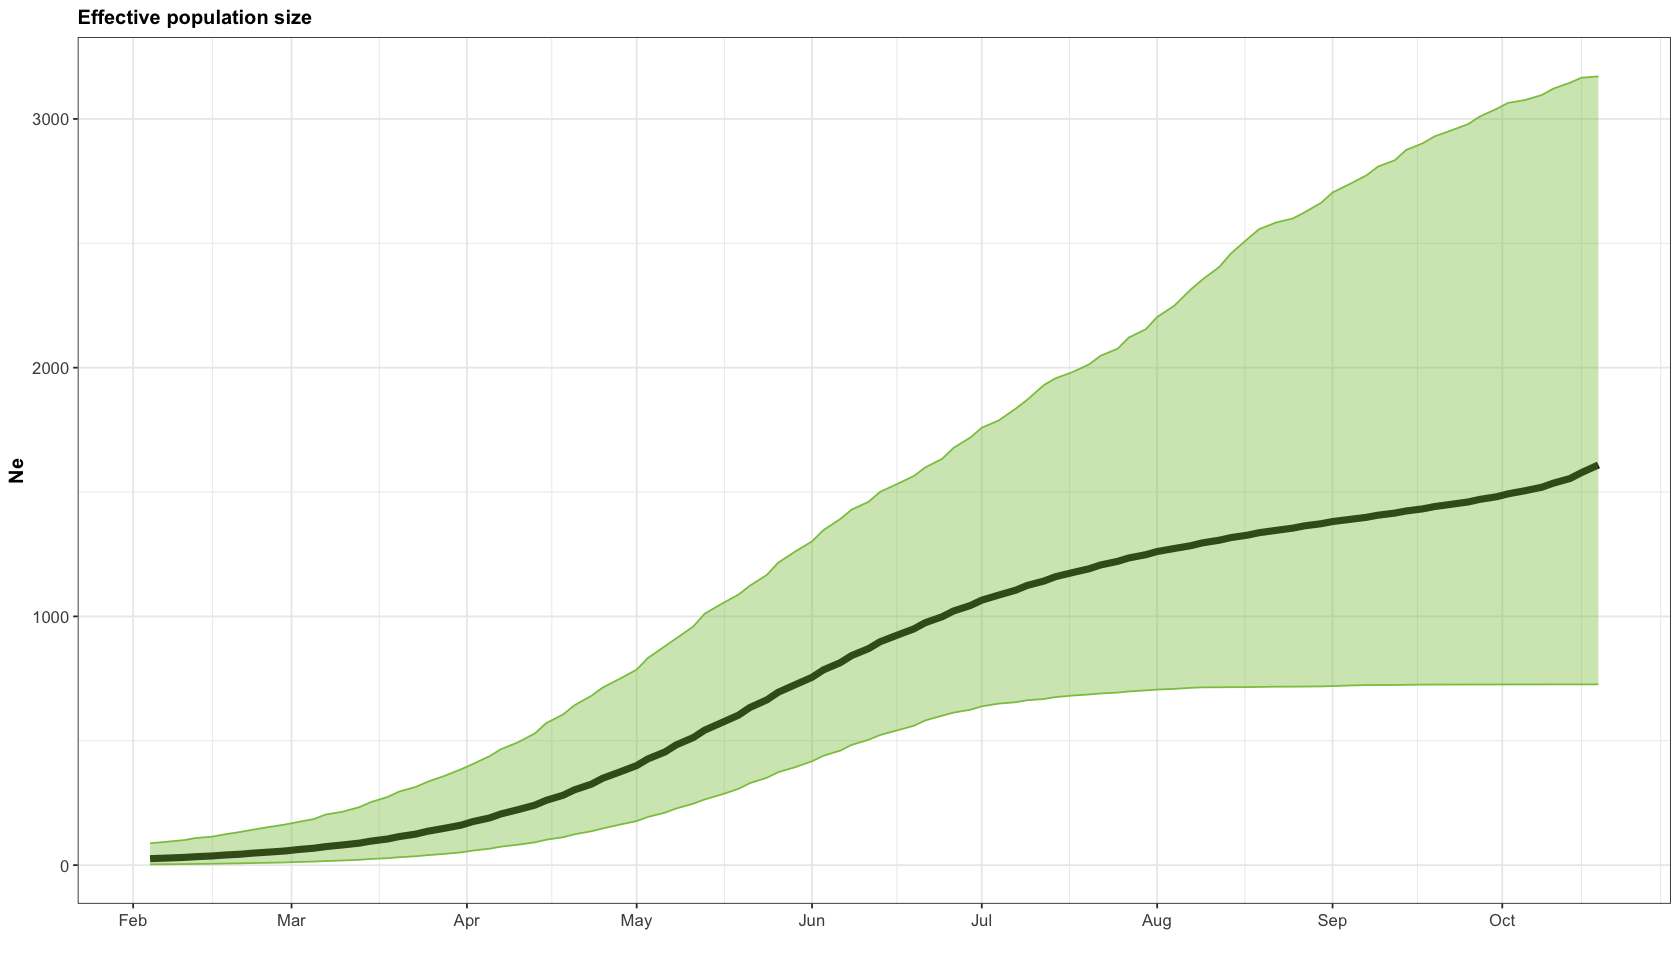

In [87]:
plot_ne_logistic <- netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab('Ne') + xlab('') + ggtitle('Effective population size') + 
          scale_x_date(date_labels = "%b", date_breaks='months') +
          my_theme()

plot_ne_logistic_blank <- netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab('') + xlab('') + 
          scale_x_date(date_labels = "%b", date_breaks='months') +
          my_theme()

plot_ne_logistic

### Read in Marlin's global case incidence estimates 

In [68]:
rtpath <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/case-rt-analysis/estimates/'

incidence <- read.table(paste0(rtpath,'case-incidence-estimates.tsv'), sep='\t', header=T)
rts <- read.table(paste0(rtpath,'case-rt-estimates.tsv'), sep='\t', header=T)

incidence <- incidence %>% filter(location=='World') %>% mutate(datetime = as_date(date))
rts <- rts %>% filter(location=='World') %>% mutate(datetime = as_date(date))

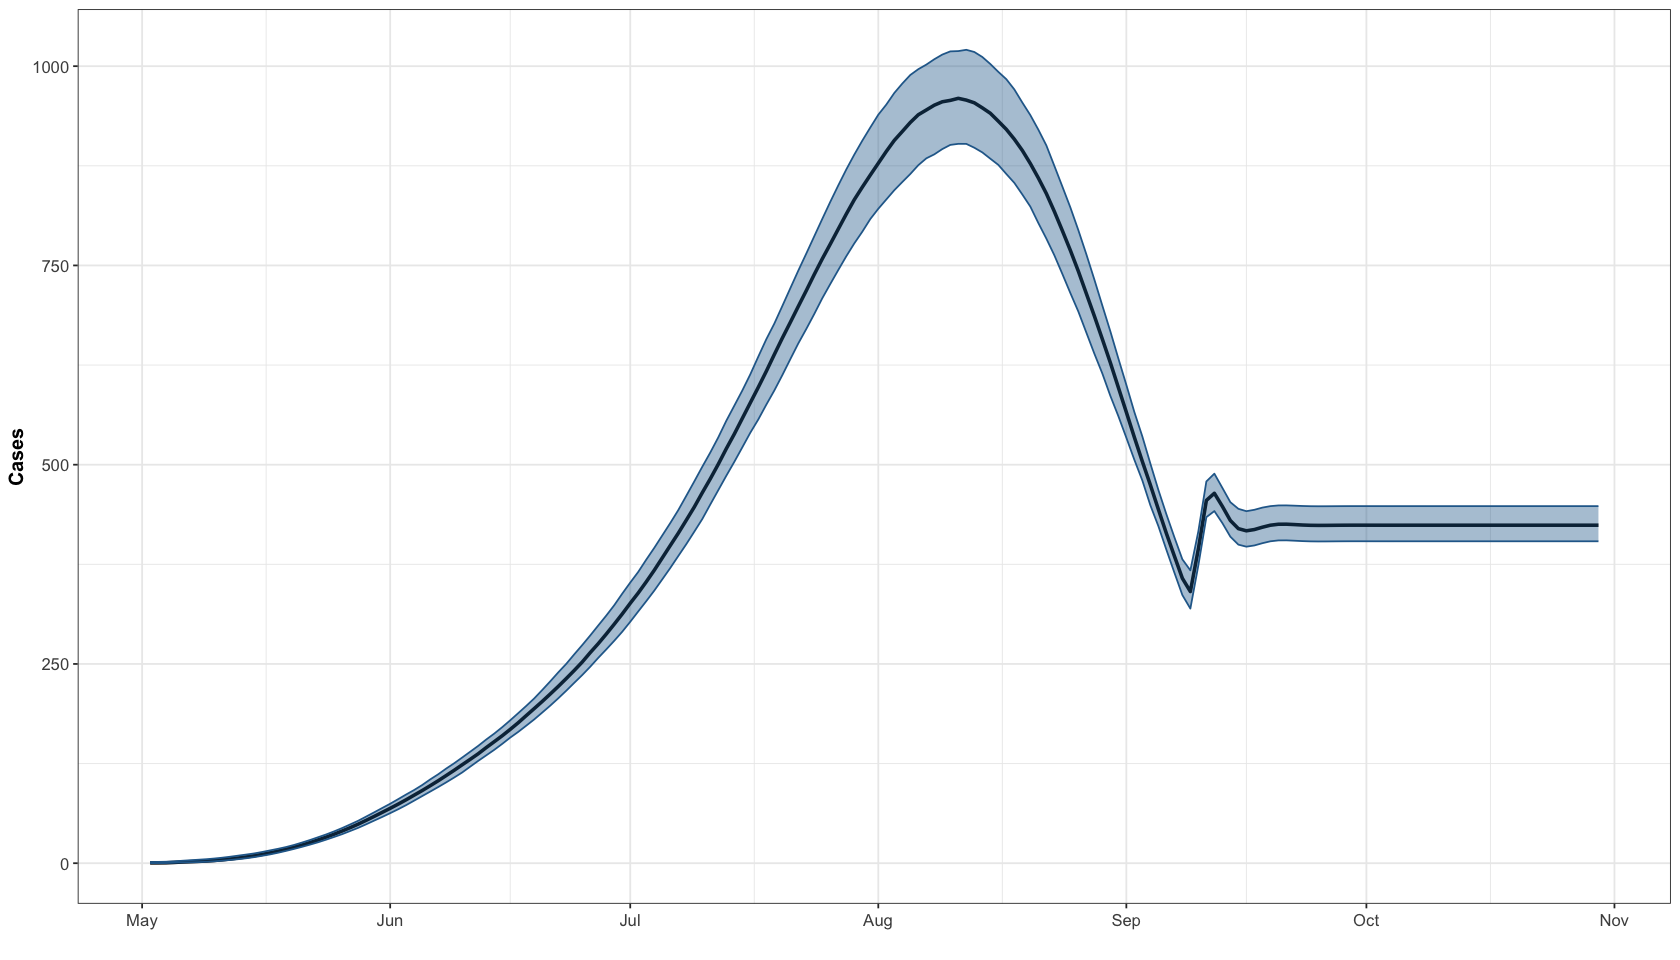

In [73]:
plot_incidence <- incidence %>% ggplot(aes(x=datetime, y=median_I_smooth, group=1)) +
              geom_line(linewidth=1, color='black') +
              geom_ribbon(aes(ymin=I_smooth_lower_80, ymax=I_smooth_upper_80), 
                          color=rgb(0.15,0.41,0.6), 
                          alpha=0.4, 
                          fill=rgb(0.15,0.41,0.6)) +
              ylab('Cases') + xlab('') + my_theme() +
              scale_x_date(date_labels = "%b", date_breaks='months') 

plot_incidence

## Overlaying case incidence estimates with Ne estimates!

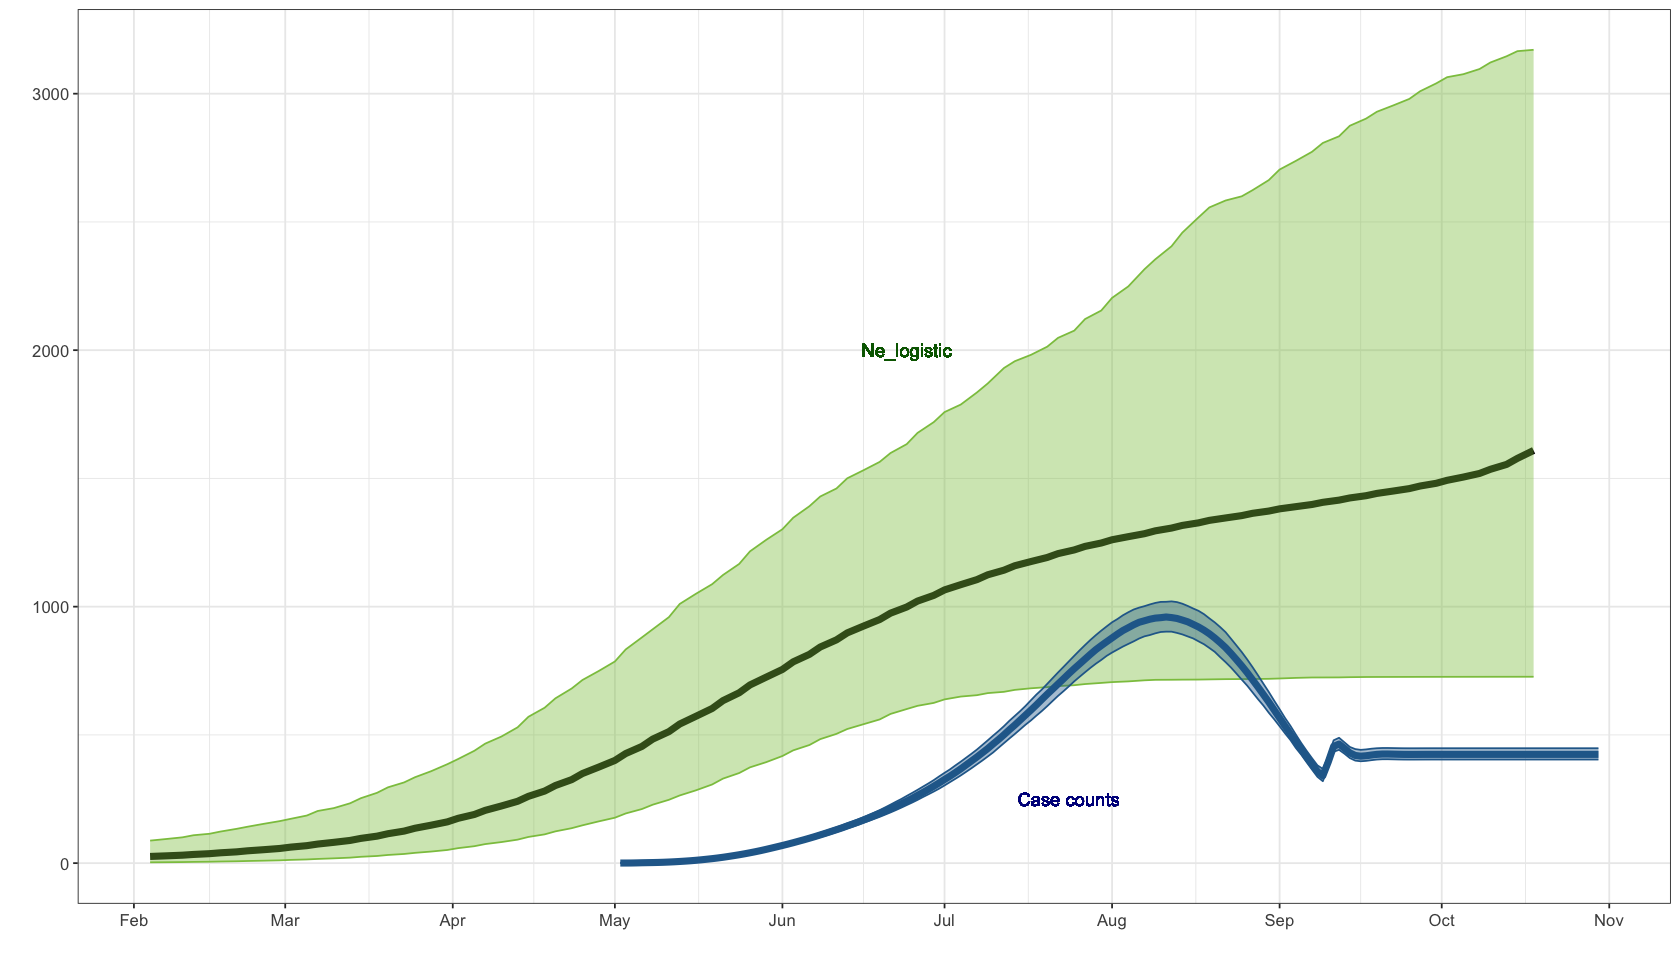

In [101]:
incidence2 <- incidence %>% mutate(ne=median_I_smooth,
                                   ne_lower=I_smooth_lower_80,
                                   ne_upper=I_smooth_upper_80)

plot_ne_logistic_blank + geom_line(data=incidence2, 
                             mapping=aes(x=datetime, y=median_I_smooth, group=1), 
                             linewidth=2,
                             color=rgb(0.15,0.41,0.6)) +
                         geom_ribbon(data=incidence2, mapping=aes(ymin=ne_lower, ymax=ne_upper),                                     
                                    color=rgb(0.15,0.41,0.6), 
                                    alpha=0.4, 
                                    fill=rgb(0.15,0.41,0.6)) +
                         geom_text(aes(x = as.Date('2022-06-24'),y=2000,label = "Ne_logistic"), color='darkgreen') +
                         geom_text(aes(x = as.Date('2022-07-24'),y=250,label = "Case counts"), color='darkblue')
                            



## NOTES/WsIP

### Plot exponential growth rate 

In [ ]:
incidence

In [119]:
# parameter estimates via tracer
#k <- 25.3132
#r <- 0.039 # in years
#taut <- 0.016 # in yers 

Warning message:
“Removed 34 row(s) containing missing values (geom_path).”


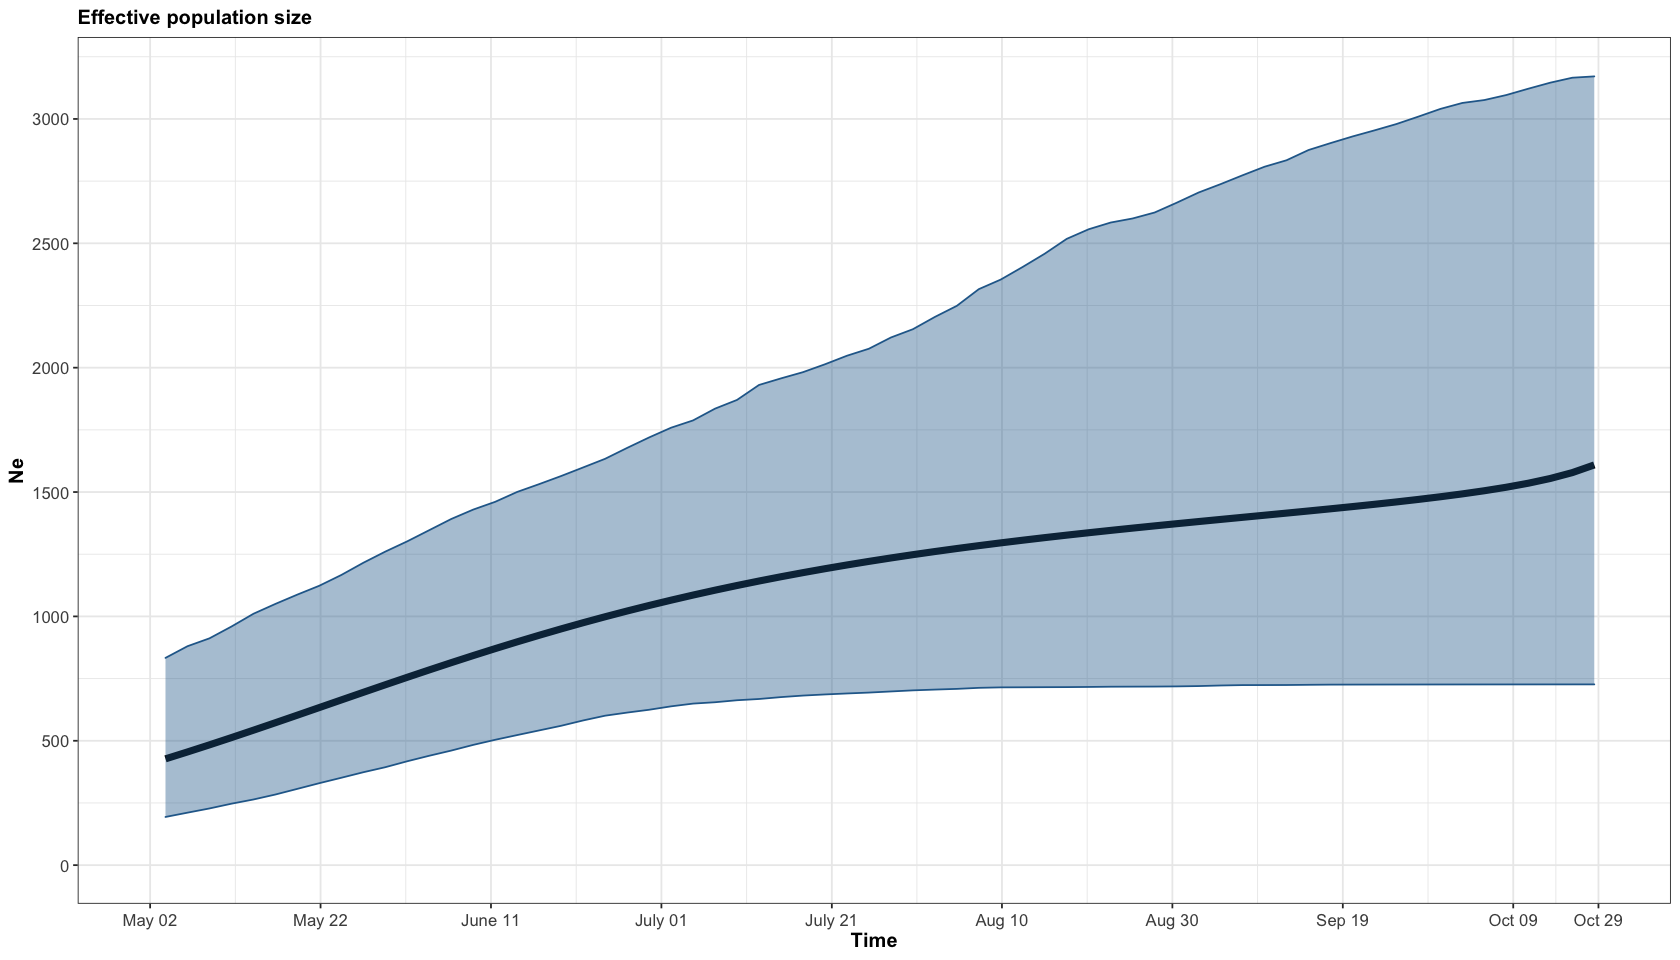

In [185]:
## do may 02 - oct 29

netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.15,0.41,0.6), alpha=0.4, fill=rgb(0.15,0.41,0.6)) +
          ylab('Ne') + xlab('') + ggtitle('Effective population size') + #xlim(c(2022.4, 2022.8)) +
          scale_x_continuous(limits=c(2022.3329,2022.7986), 
                             breaks=c(2022.3329, 2022.3877, 2022.4425, 2022.4973,
                                     2022.5521, 2022.6068, 2022.6616,2022.7164, 2022.7712, 2022.7986), 
                             labels=c('May 02','May 22','June 11','July 01', 'July 21',
                                      'Aug 10', 'Aug 30', 'Sep 19', 'Oct 09', 'Oct 29')) +
          scale_y_continuous(breaks=c(0, 500, 1000, 1500, 2000, 2500, 3000)) +
          my_theme()